In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.ndimage as spn 
import pickle


from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, permutation_test_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from joblib import Parallel, delayed

In [2]:
lab_desktop = True
if lab_desktop : 
    data_path = '/home/INT/mifsud.l/Bureau/pattern_classification_git/results/'
    result_path = '/home/INT/mifsud.l/Bureau/pattern_classification_git/results/'
else : 
    data_path = '/home/laurie/Bureau/pattern_classification_git/results/' 
    result_path = '/home/laurie/Bureau/pattern_classification_git/results/'

In [3]:
target = pd.read_csv(data_path + 'target.csv')

event_labels = np.load(data_path + 'event_labels.npy')
event_vector = np.load(data_path + 'event_vector.npy')

spike_convolved = np.load(data_path +  'spike_convolved.npy')
spike_convolved_shuff = np.load(data_path + 'spike_convol_shuff.npy')

synchrony = np.load(data_path +  'synchrony.npy')
synchrony_shuff_tt = np.load(data_path + 'synchrony_shuff_tt.npy')
synchrony_shuff_pos = np.load(data_path + 'synchrony_shuff_pos.npy')

n_trials, n_times, n_neurons = spike_convolved.shape
n_pairs = synchrony.shape[2]

In [4]:
# Open the file for reading
filename_tt = 'list_shuffled_sync_tt.pkl'
file_object_tt = open(f'{result_path}/{filename_tt}', 'rb')

# Load the list from the file
list_shuffled_sync_tt = pickle.load(file_object_tt)

# Close the file
file_object_tt.close()

filename_pos = 'list_shuffled_sync_pos.pkl'
file_object_pos = open(f'{result_path}/{filename_pos}', 'rb')

# Load the list from the file
list_shuffled_sync_pos = pickle.load(file_object_pos)

# Close the file
file_object_pos.close()

In [6]:
# Build pipeline
n_splits = 2
n_permutations = 5
# Cross-validation scheme
cvs0 = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2)
# Standardisation scheme
scaler = StandardScaler()
# Algo
#estimator = HistGradientBoostingClassifier(max_iter=5, max_depth=10, max_bins=10)
#estimator = HistGradientBoostingClassifier(max_iter=5, max_depth=3)
#clf = make_pipeline(scaler, estimator)

#clf = LinearDiscriminantAnalysis()

clf = make_pipeline(scaler, RandomForestClassifier())

def classify_2D(X, y):
    score, perm_score, pval = permutation_test_score(clf, X, y, cv=cvs0, n_jobs=1, n_permutations=n_permutations, random_state=20)
    return score, perm_score

def destroy_corr(x, y):
    rng = np.random.default_rng() #ramdom seed
    n_samples, n_times, n_feat = x.shape 
    y_u = np.unique(y)
    x_dc = x.copy()

    for n_y in y_u:
        is_class = y == n_y
        x_dc[is_class, :, :] = rng.permuted(x[is_class, :, :], axis=0)
    return x_dc

def classify_3D(X, y, shuffle=False, repeat=1, n_permutations=n_permutations):
    n_times = X.shape[1]
    da = np.zeros((repeat, n_times))
    perm = np.zeros((repeat, n_times, n_permutations))
    for p in range(n_repeat) :
        if shuffle
        out = Parallel(n_jobs=-1)(delayed(classify_2D)(X[:,t:t+200,:].mean(axis=1), y) for t in np.arange(0,n_times,200))
        da, perm = zip(*out)
        da = np.array(da)
        perm = np.array(perm)
    return da, perm  

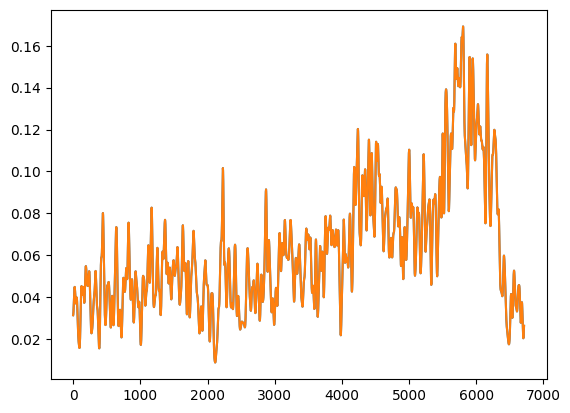

In [37]:
plt.plot(spike_convolved[:,:,0].mean(axis=0));
plt.plot(spike_convolved_shuff[:,:,0].mean(axis=0));

# Classify firing rate

In [18]:
var = spike_convolved

# Compute da and perm for the first variable (position)
da_pos, perm_pos = classify_3D(var, target['position'].values)
# Compute da and perm for the second variable (trial_type)
da_tt, perm_tt = classify_3D(var, target['trial_type'].values)

/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/IN

In [19]:
perm_tt.shape

(37, 5)

In [39]:
percentile_perm_pos = np.nanpercentile(perm_pos, 95, axis=1)
percentile_perm_tt = np.nanpercentile(perm_tt, 95, axis=1)

In [40]:
# Concatenate da and perm for the two variables
data = np.concatenate((da_pos, percentile_perm_pos, da_tt, percentile_perm_tt))

In [41]:
# Define types and times
types = np.concatenate((np.full(len(da_pos), 'test'),
                          np.full(len(percentile_perm_pos), 'chance_level'),
                          np.full(len(da_tt), 'test'),
                          np.full(len(percentile_perm_tt), 'chance_level')))

times = np.concatenate([np.arange(0, n_times, 200),
                         np.arange(0, n_times, 200),
                         np.arange(0, n_times, 200),
                         np.arange(0, n_times, 200)])

# Define target_types
target_types = np.concatenate((np.full(len(da_pos) + len(percentile_perm_pos), 'position'),
                                 np.full(len(da_tt) + len(percentile_perm_tt), 'trial_type')))

In [42]:
# Create a DataFrame with four columns
df = pd.DataFrame({'time': times,
                    'data_type': types,
                    'target_type': target_types,
                    'accuracy': data})

In [43]:
df

,time,data_type,target_type,accuracy
0,0,test,position,0.291667
1,200,test,position,0.208333
2,400,test,position,0.180556
3,600,test,position,0.333333
4,800,test,position,0.333333
...,...,...,...,...
143,6400,chance_level,trial_type,0.427778
144,6600,chance_level,trial_type,0.425000
145,6800,chance_level,trial_type,0.416667
146,7000,chance_level,trial_type,0.416667


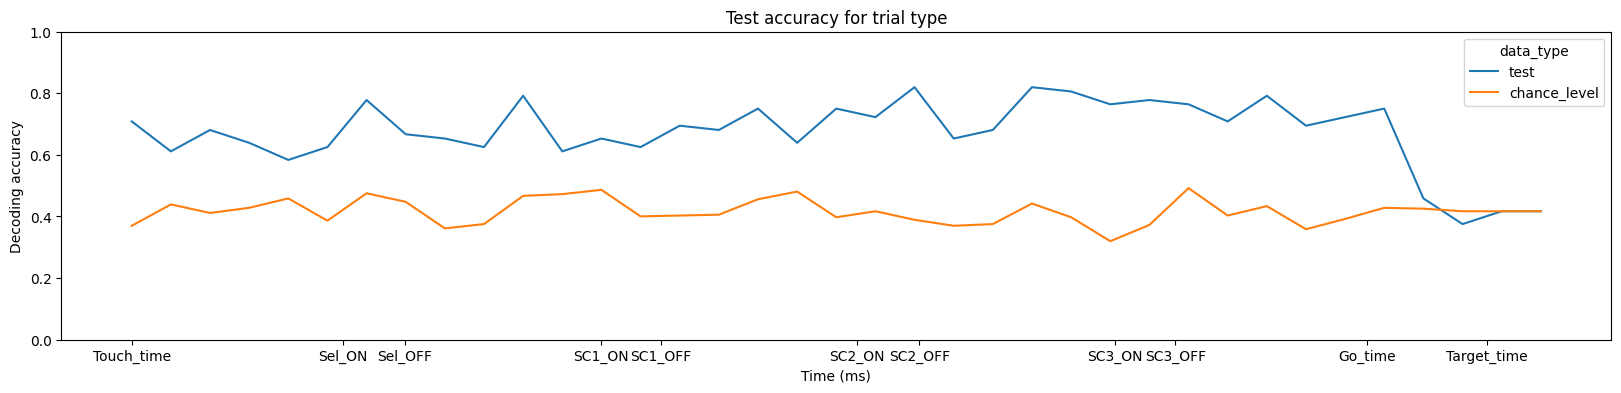

In [44]:
data_tt = df[(df['target_type'] == 'trial_type')]
# Create a line plot for the trial type test accuracy
plt.figure(figsize=(20,4))
sns.lineplot(x='time', y='accuracy', data=data_tt, hue='data_type')
plt.xticks(event_vector, event_labels)
plt.ylim(0,1)
plt.xlabel('Time (ms)')
plt.ylabel('Decoding accuracy')
plt.title('Test accuracy for trial type')
plt.show()


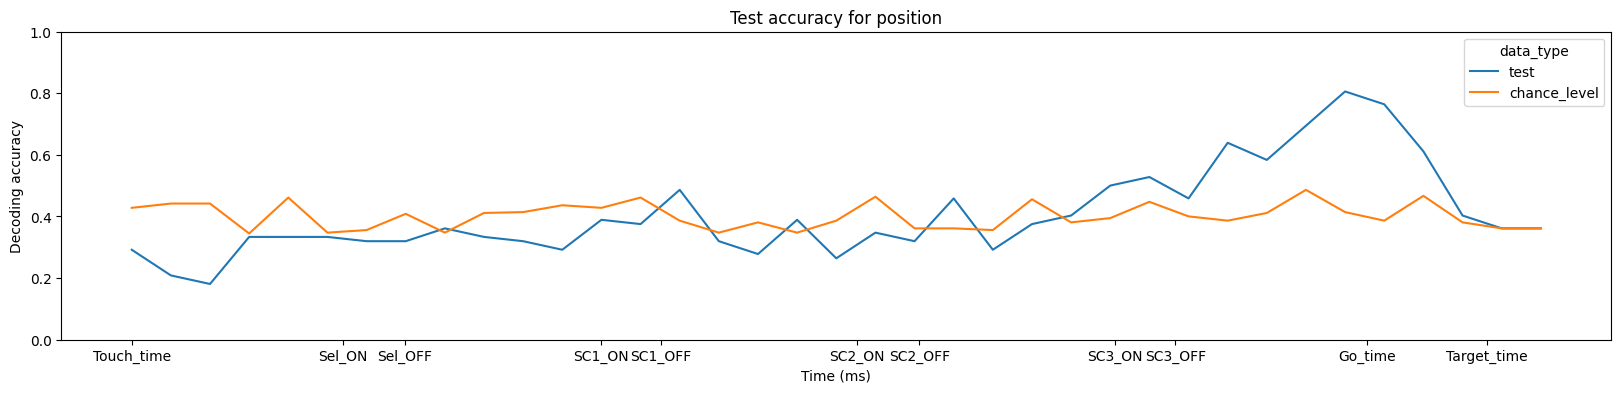

In [45]:
data_pos = df[(df['target_type'] == 'position')]
# Create a line plot for the trial type test accuracy
plt.figure(figsize=(20,4))
sns.lineplot(x='time', y='accuracy', data=data_pos, hue='data_type')
plt.xticks(event_vector, event_labels)
plt.ylim(0,1)
plt.xlabel('Time (ms)')
plt.ylabel('Decoding accuracy')
plt.title('Test accuracy for position')
plt.show()

# Classify shuffled_firing rate

In [46]:
var = spike_convolved_shuff

# Compute da and perm for the first variable (position)
da_pos, perm_pos = classify_3D(var, target['position'].values)
# Compute da and perm for the second variable (trial_type)
da_tt, perm_tt = classify_3D(var, target['trial_type'].values)

/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/IN

In [47]:
percentile_perm_pos = np.nanpercentile(perm_pos, 95, axis=1)
percentile_perm_tt = np.nanpercentile(perm_tt, 95, axis=1)

In [48]:
# Concatenate da and perm for the two variables
data = np.concatenate((da_pos, percentile_perm_pos, da_tt, percentile_perm_tt))

In [49]:
# Define types and times
types = np.concatenate((np.full(len(da_pos), 'test'),
                          np.full(len(percentile_perm_pos), 'chance_level'),
                          np.full(len(da_tt), 'test'),
                          np.full(len(percentile_perm_tt), 'chance_level')))

times = np.concatenate([np.arange(0, n_times, 200),
                         np.arange(0, n_times, 200),
                         np.arange(0, n_times, 200),
                         np.arange(0, n_times, 200)])

# Define target_types
target_types = np.concatenate((np.full(len(da_pos) + len(percentile_perm_pos), 'position'),
                                 np.full(len(da_tt) + len(percentile_perm_tt), 'trial_type')))

In [50]:
# Create a DataFrame with four columns
df = pd.DataFrame({'time': times,
                    'data_type': types,
                    'target_type': target_types,
                    'accuracy': data})

In [51]:
df

,time,data_type,target_type,accuracy
0,0,test,position,0.347222
1,200,test,position,0.250000
2,400,test,position,0.319444
3,600,test,position,0.236111
4,800,test,position,0.347222
...,...,...,...,...
143,6400,chance_level,trial_type,0.402778
144,6600,chance_level,trial_type,0.416667
145,6800,chance_level,trial_type,0.416667
146,7000,chance_level,trial_type,0.416667


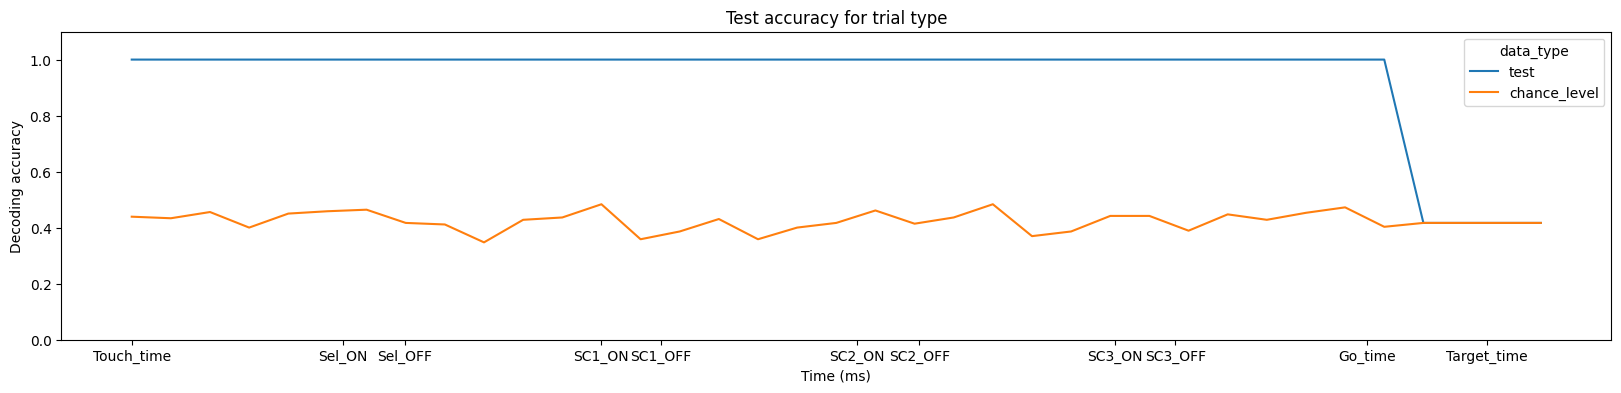

In [52]:
data_tt = df[(df['target_type'] == 'trial_type')]
# Create a line plot for the trial type test accuracy
plt.figure(figsize=(20,4))
sns.lineplot(x='time', y='accuracy', data=data_tt, hue='data_type')
plt.xticks(event_vector, event_labels)
plt.ylim(0,1.1)
plt.xlabel('Time (ms)')
plt.ylabel('Decoding accuracy')
plt.title('Test accuracy for trial type')
plt.show()


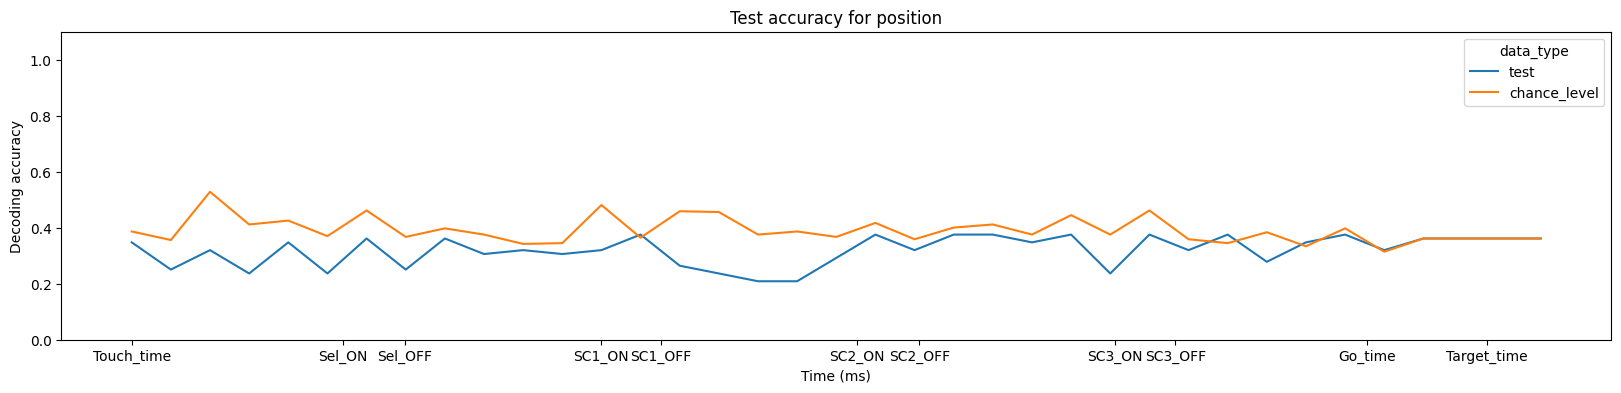

In [53]:
data_pos = df[(df['target_type'] == 'position')]
# Create a line plot for the trial type test accuracy
plt.figure(figsize=(20,4))
sns.lineplot(x='time', y='accuracy', data=data_pos, hue='data_type')
plt.xticks(event_vector, event_labels)
plt.ylim(0,1.1)
plt.xlabel('Time (ms)')
plt.ylabel('Decoding accuracy')
plt.title('Test accuracy for position')
plt.show()

# Sanity check

In [54]:
from sklearn.decomposition import PCA

In [55]:
t = 1300

def pca(X, y):
    X_m = X[:,t:t+200,:].mean(axis=1)
    model = PCA(n_components=2)
    X_tr = model.fit_transform(X_m)
    df = pd.DataFrame({'comp1': X_tr[:,0], 'comp2':X_tr[:,1], 'y': y})
    return df

In [56]:
df = pca(spike_convolved, target['position'])

In [57]:
df

,comp1,comp2,y
0,-0.753055,0.371240,2
1,-1.258636,0.185832,2
2,-1.511530,0.662786,3
3,-0.346269,-0.057524,3
4,-0.477877,-0.055679,4
...,...,...,...
171,1.325982,0.536549,3
172,0.956167,0.121823,3
173,1.089313,0.242962,4
174,0.918566,0.096798,4


<Axes: xlabel='comp1', ylabel='comp2'>

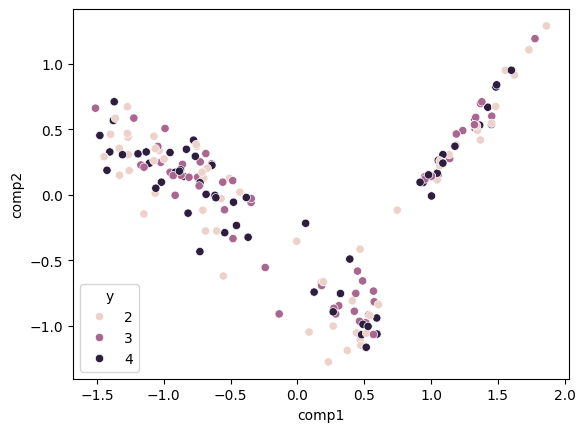

In [58]:
sns.scatterplot(data=df, x='comp1', y='comp2', hue='y')

In [59]:
df = pca(spike_convolved_shuff, target['position'])

<Axes: xlabel='comp1', ylabel='comp2'>

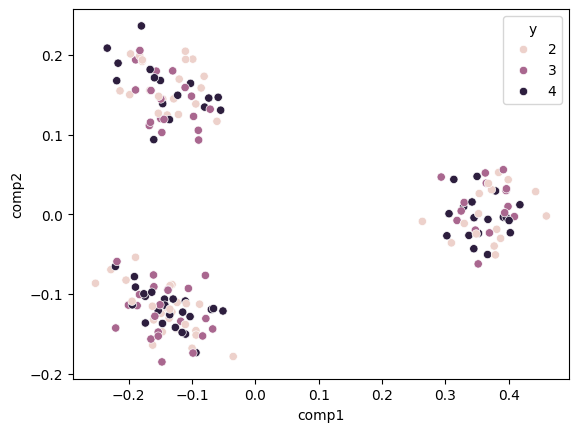

In [60]:
sns.scatterplot(data=df, x='comp1', y='comp2', hue='y')

# Classify synchrony

In [61]:
var = synchrony

# Compute da and perm for the first variable (position)
da_pos, perm_pos = classify_3D(var, target['position'].values)
# Compute da and perm for the second variable (trial_type)
da_tt, perm_tt = classify_3D(var, target['trial_type'].values)

/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/IN

In [62]:
percentile_perm_pos = np.nanpercentile(perm_pos, 95, axis=1)
percentile_perm_tt = np.nanpercentile(perm_tt, 95, axis=1)
# Concatenate da and perm for the two variables
data = np.concatenate((da_pos, percentile_perm_pos, da_tt, percentile_perm_tt))
# Define types and times
types = np.concatenate((np.full(len(da_pos), 'test'),
                          np.full(len(percentile_perm_pos), 'chance_level'),
                          np.full(len(da_tt), 'test'),
                          np.full(len(percentile_perm_tt), 'chance_level')))

times = np.concatenate([np.arange(0, n_times, 200),
                         np.arange(0, n_times, 200),
                         np.arange(0, n_times, 200),
                         np.arange(0, n_times, 200)])

# Define target_types
target_types = np.concatenate((np.full(len(da_pos) + len(percentile_perm_pos), 'position'),
                                 np.full(len(da_tt) + len(percentile_perm_tt), 'trial_type')))

In [63]:
# Create a DataFrame with four columns
df = pd.DataFrame({'time': times,
                    'data_type': types,
                    'target_type': target_types,
                    'accuracy': data})
df

,time,data_type,target_type,accuracy
0,0,test,position,0.263889
1,200,test,position,0.277778
2,400,test,position,0.208333
3,600,test,position,0.347222
4,800,test,position,0.236111
...,...,...,...,...
143,6400,chance_level,trial_type,0.433333
144,6600,chance_level,trial_type,0.427778
145,6800,chance_level,trial_type,0.416667
146,7000,chance_level,trial_type,0.394444


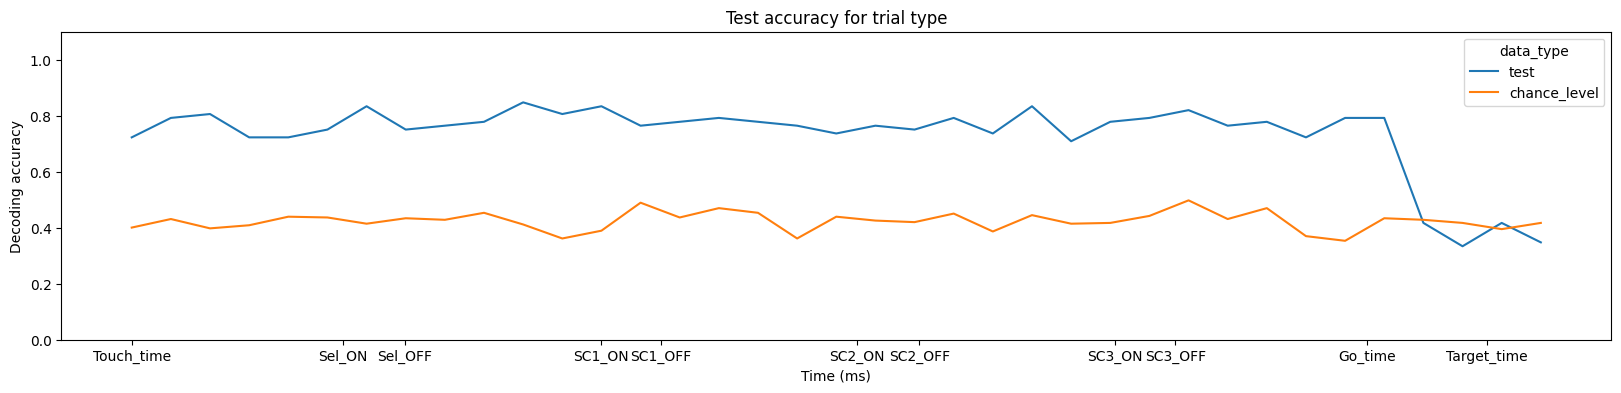

In [64]:
data_tt = df[(df['target_type'] == 'trial_type')]
# Create a line plot for the trial type test accuracy
plt.figure(figsize=(20,4))
sns.lineplot(x='time', y='accuracy', data=data_tt, hue='data_type')
plt.xticks(event_vector, event_labels)
plt.ylim(0,1.1)
plt.xlabel('Time (ms)')
plt.ylabel('Decoding accuracy')
plt.title('Test accuracy for trial type')
plt.show()


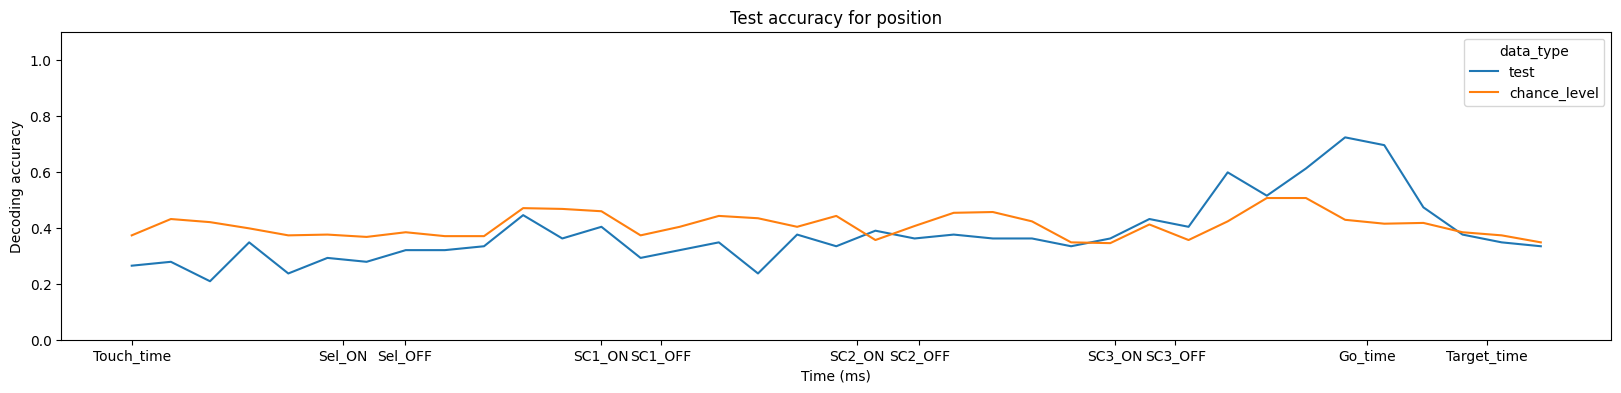

In [65]:
data_pos = df[(df['target_type'] == 'position')]
# Create a line plot for the trial type test accuracy
plt.figure(figsize=(20,4))
sns.lineplot(x='time', y='accuracy', data=data_pos, hue='data_type')
plt.xticks(event_vector, event_labels)
plt.ylim(0,1.1)
plt.xlabel('Time (ms)')
plt.ylabel('Decoding accuracy')
plt.title('Test accuracy for position')
plt.show()

# Classify Shuffled synchrony

In [169]:
var_tt = synchrony_shuff_tt
var_pos = synchrony_shuff_pos
# Compute da and perm for the first variable (position)
da_pos, perm_pos = classify_3D(var_tt, target['position'].values)
# Compute da and perm for the second variable (trial_type)
da_tt, perm_tt = classify_3D(var_pos, target['trial_type'].values)

/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/INT/m

In [170]:
percentile_perm_pos = np.nanpercentile(perm_pos, 95, axis=1)
percentile_perm_tt = np.nanpercentile(perm_tt, 95, axis=1)
# Concatenate da and perm for the two variables
data = np.concatenate((da_pos, percentile_perm_pos, da_tt, percentile_perm_tt))
# Define types and times
types = np.concatenate((np.full(len(da_pos), 'test'),
                          np.full(len(percentile_perm_pos), 'chance_level'),
                          np.full(len(da_tt), 'test'),
                          np.full(len(percentile_perm_tt), 'chance_level')))

times = np.concatenate([np.arange(0, n_times, 200),
                         np.arange(0, n_times, 200),
                         np.arange(0, n_times, 200),
                         np.arange(0, n_times, 200)])

# Define target_types
target_types = np.concatenate((np.full(len(da_pos) + len(percentile_perm_pos), 'position'),
                                 np.full(len(da_tt) + len(percentile_perm_tt), 'trial_type')))

In [171]:
# Create a DataFrame with four columns
df = pd.DataFrame({'time': times,
                    'data_type': types,
                    'target_type': target_types,
                    'accuracy': data})
df

,time,data_type,target_type,accuracy
0,0,test,position,0.222222
1,200,test,position,0.333333
2,400,test,position,0.333333
3,600,test,position,0.305556
4,800,test,position,0.222222
...,...,...,...,...
143,6400,chance_level,trial_type,0.483333
144,6600,chance_level,trial_type,0.438889
145,6800,chance_level,trial_type,0.416667
146,7000,chance_level,trial_type,0.416667


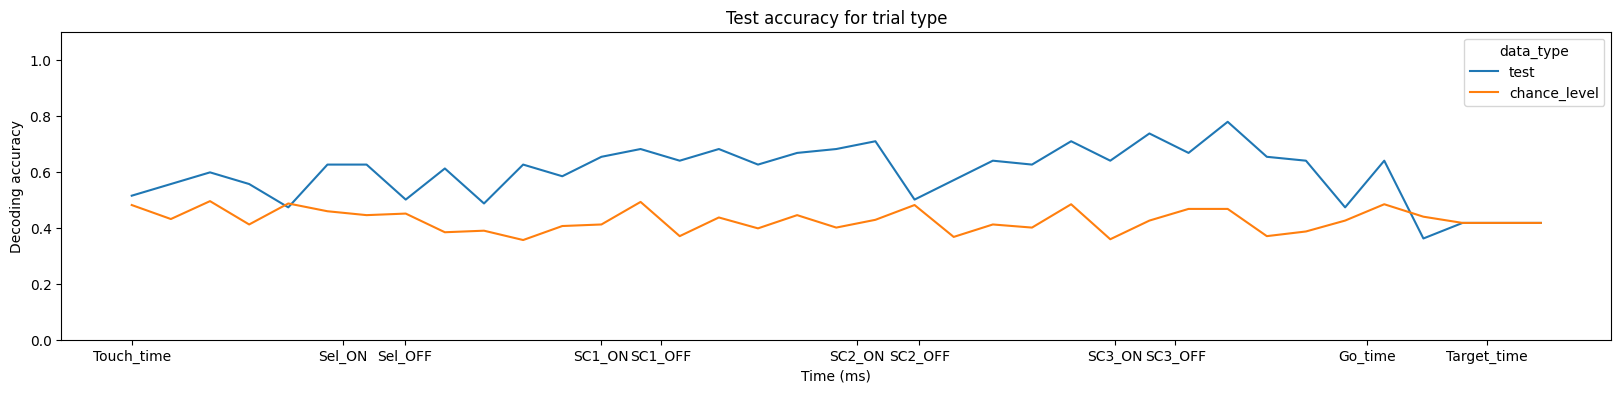

In [172]:
data_tt = df[(df['target_type'] == 'trial_type')]
# Create a line plot for the trial type test accuracy
plt.figure(figsize=(20,4))
sns.lineplot(x='time', y='accuracy', data=data_tt, hue='data_type')
plt.xticks(event_vector, event_labels)
plt.ylim(0,1.1)
plt.xlabel('Time (ms)')
plt.ylabel('Decoding accuracy')
plt.title('Test accuracy for trial type')
plt.show()


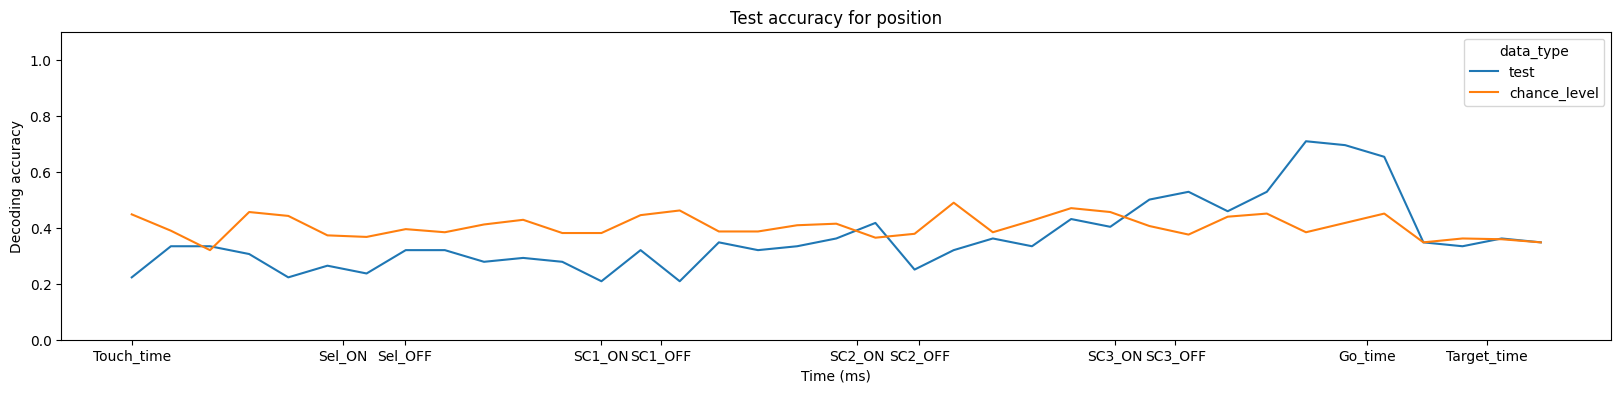

In [173]:
data_pos = df[(df['target_type'] == 'position')]
# Create a line plot for the trial type test accuracy
plt.figure(figsize=(20,4))
sns.lineplot(x='time', y='accuracy', data=data_pos, hue='data_type')
plt.xticks(event_vector, event_labels)
plt.ylim(0,1.1)
plt.xlabel('Time (ms)')
plt.ylabel('Decoding accuracy')
plt.title('Test accuracy for position')
plt.show()

# Classify n_Shuffled synchrony

In [12]:
n_shuf = len(list_shuffled_sync_tt)
da_pos = np.zeros(n_shuf, dtype=object)
perm_pos = np.zeros(n_shuf, dtype=object)
da_tt = np.zeros(n_shuf, dtype=object)
perm_tt = np.zeros(n_shuf, dtype=object)
percentile_perm_pos = np.zeros(n_shuf, dtype=object)
percentile_perm_tt = np.zeros(n_shuf, dtype=object)

for i in range(n_shuf):
    da_pos[i], perm_pos[i] = classify_3D(list_shuffled_sync_pos[i], target['position'].values)
    da_tt[i], perm_tt[i] = classify_3D(list_shuffled_sync_tt[i], target['trial_type'].values)
    percentile_perm_pos[i] = np.nanpercentile(perm_pos[i], 95, axis=1)
    percentile_perm_tt[i] = np.nanpercentile(perm_tt[i], 95, axis=1)


/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/IN

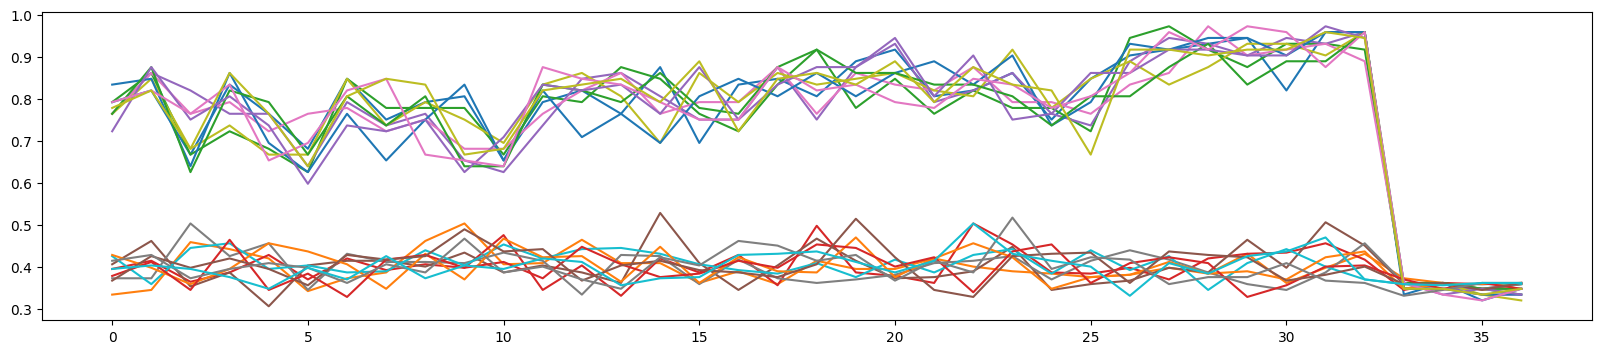

In [15]:
plt.figure(figsize=(20,4))

for i in range(n_shuf):
    plt.plot(da_pos[i])
    plt.plot(percentile_perm_pos[i])

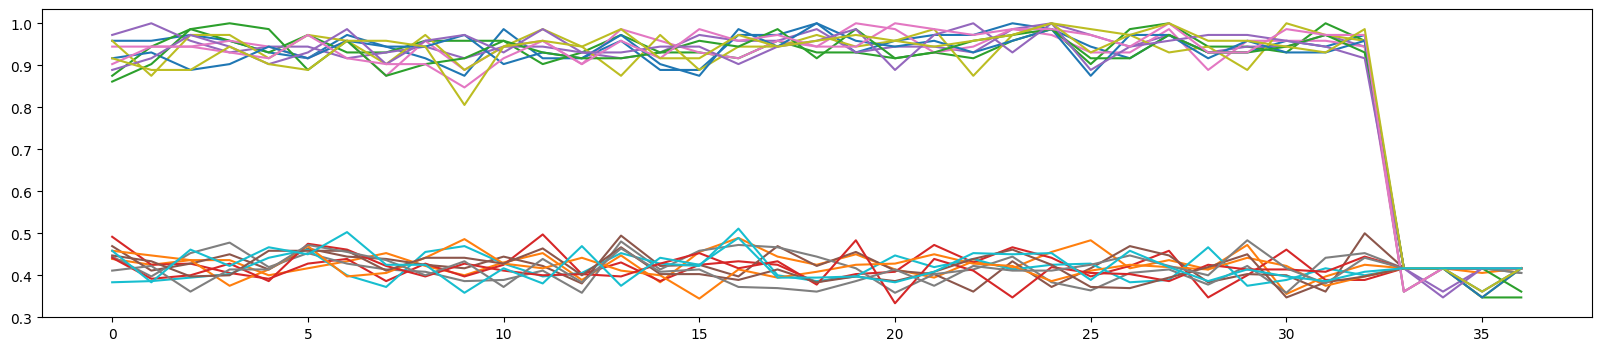

In [16]:
plt.figure(figsize=(20,4))

for i in range(n_shuf):
    plt.plot(da_tt[i])
    plt.plot(percentile_perm_tt[i])